In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in "input/" directory

In [4]:

# Read the data
X_full = pd.read_csv('input/train.csv', index_col='id')
X_test_full = pd.read_csv('input/test.csv', index_col='id')

In [5]:
from scipy import stats


def treatoutliers(df=None, columns=None, factor=3, method='IQR', treatment='cap'):

    for column in columns:
        if method == 'STD':
            permissable_std = factor * df[column].std()
            col_mean = df[column].mean()
            floor, ceil = col_mean - permissable_std, col_mean + permissable_std
        elif method == 'IQR':
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            floor, ceil = Q1 - factor * IQR, Q3 + factor * IQR
#         print(floor, ceil)
        if treatment == 'remove':
            #print(treatment, column)
            df = df[(df[column] >= floor) & (df[column] <= ceil)]
        elif treatment == 'cap':
            #print(treatment, column)
            df[column] = df[column].clip(floor, ceil)

    return df
    
#remove outliere from target column 
#for colName in [['target']]:
    #X_full = treatoutliers(df=X_full,columns=colName, treatment='remove')         
    
#Quantile-based Flooring and Capping
#for colName in [['target','cont0','cont6','cont8']]:
  #  X_full = treatoutliers(df=X_full,columns=colName, treatment='cap') 

# **Data Preprocessing**

In [6]:
# Remove rows with missing target, separate target from predictors
X_full.dropna(axis=0, subset=['target'], inplace=True)
y = X_full.target              
X= X_full.copy()

X.drop(['target'], axis=1, inplace=True)
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)



# Select all categorical columns 
low_cardinality_cols = [cname for cname in X.columns if #X[cname].nunique() < 10000 and 
                        X[cname].dtype == "object"]

# Select numeric columns
numeric_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = low_cardinality_cols + numeric_cols
X = X[my_cols].copy()

X_test = X_test_full[my_cols].copy()
X_test.reset_index(drop=True, inplace=True)



In [7]:
# custome encoder function to reduce number of unique values in high cardinality columns
def cust_enc(data,data2):
    #data=X.copy()
    colu=[cname for cname in data.columns if X[cname].nunique() > 10 and data[cname].dtype == "object"]
    for i in range(len(colu)):
        df=data[colu[i]].value_counts()
        conditions=[]
        conditions_1=[]
        choices=[]
        #print(df)
        for k in range(len(df)):
            if df.iloc[k]/df.sum()>0.05:
                choices.append(df.index[k])
                conditions.append(data[colu[i]].str.contains(df.index[k]))
                conditions_1.append(data2[colu[i]].str.contains(df.index[k]))
        print(choices)
        data[(colu[i])] = np.select(conditions, choices, default='X')
        data2[(colu[i])] = np.select(conditions_1, choices, default='X')
    return data, data2
    
X,X_test=cust_enc(X,X_test)       

['F', 'I', 'G', 'L', 'H', 'K', 'N']


# Model genration and fitting****

In [8]:
#Importing required libraries
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import KFold

# Setting up fold parameters
parameters = {'learning_rate': 0.03628302216953097,
        'subsample': 0.7875490025178,
        'colsample_bytree': 0.11807135201147,
        'max_depth': 3,
        'booster': 'gbtree', 
        'reg_lambda': 0.0008746338866473539,
        'reg_alpha': 23.13181079976304,
        'random_state':40,
        'n_estimators':10000}

# Kforld validation settings
splits = 5
skf = KFold(n_splits=splits, shuffle=True, random_state=42)

# Creating an array of zeros for storing "out of fold" predictions
oof_preds = np.zeros((X.shape[0],))
preds = np.zeros((X_test.shape[0],))
model_fi = 0
total_mean_rmse = 0
fold_rmse=np.zeros(splits)
X_test1=X_test.copy()
for num, (train_idx, valid_idx) in enumerate(skf.split(X)):
    
    X_train, X_valid = X.loc[train_idx], X.loc[valid_idx]
    y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]
    X_test=X_test1.copy()
    
    #encoding the categpry variables using ordinal encoder
    enc=OrdinalEncoder()
    X_train[low_cardinality_cols]=enc.fit_transform(X_train[low_cardinality_cols])
    X_valid[low_cardinality_cols]=enc.transform(X_valid[low_cardinality_cols])
    X_test[low_cardinality_cols]=enc.transform(X_test[low_cardinality_cols])
    X_f=pd.concat([X_train,y_train], axis =1)
    for colName in [['target','cont0','cont6','cont8']]:
        X_f= treatoutliers(df=X_f,columns=colName, treatment='cap') 
    y_train= X_f.target
    X_train=X_f.copy()
    X_train.drop(['target'], axis=1, inplace=True)
    
    
    
    #define model
    model = XGBRegressor(**parameters, 
                         tree_method = 'gpu_hist',
                         predictor='gpu_predictor',
                         #sampling_method='gradient_based',
                         n_jobs=4
                         )
    #fitting model
    model.fit(X_train, y_train,
              verbose=0,
              eval_set=[(X_valid, y_valid)],
              eval_metric="rmse",
              early_stopping_rounds=300,
              )
    
    # Getting mean test data predictions (i.e. devided by number of splits)
    preds+= model.predict(X_test) / splits
    
    # Getting mean feature importances (i.e. devided by number of splits)
    model_fi += model.feature_importances_ / splits
    
    # Getting validation data predictions. Each fold model makes predictions on an unseen data.
    # So in the end it will be completely filled with unseen data predictions.
    # It will be used to evaluate hyperparameters performance only.
    oof_preds[valid_idx] = model.predict(X_valid)
    
    # Getting score for a fold model
    fold_rmse[num] = np.sqrt(mean_squared_error(y_valid, oof_preds[valid_idx]))
    print(f"Fold {num} RMSE: {fold_rmse[num]}")

    # Getting mean score of all fold models (i.e. devided by number of splits)
    total_mean_rmse = fold_rmse.sum() / splits
    
print(f"\nOverall RMSE: {total_mean_rmse}")

Fold 0 RMSE: 0.7168550110625964
Fold 1 RMSE: 0.716697110493304
Fold 2 RMSE: 0.7186701624336042
Fold 3 RMSE: 0.7185693150148843
Fold 4 RMSE: 0.7171699092056233

Overall RMSE: 0.7175923016420025


# Feature Importances graph****

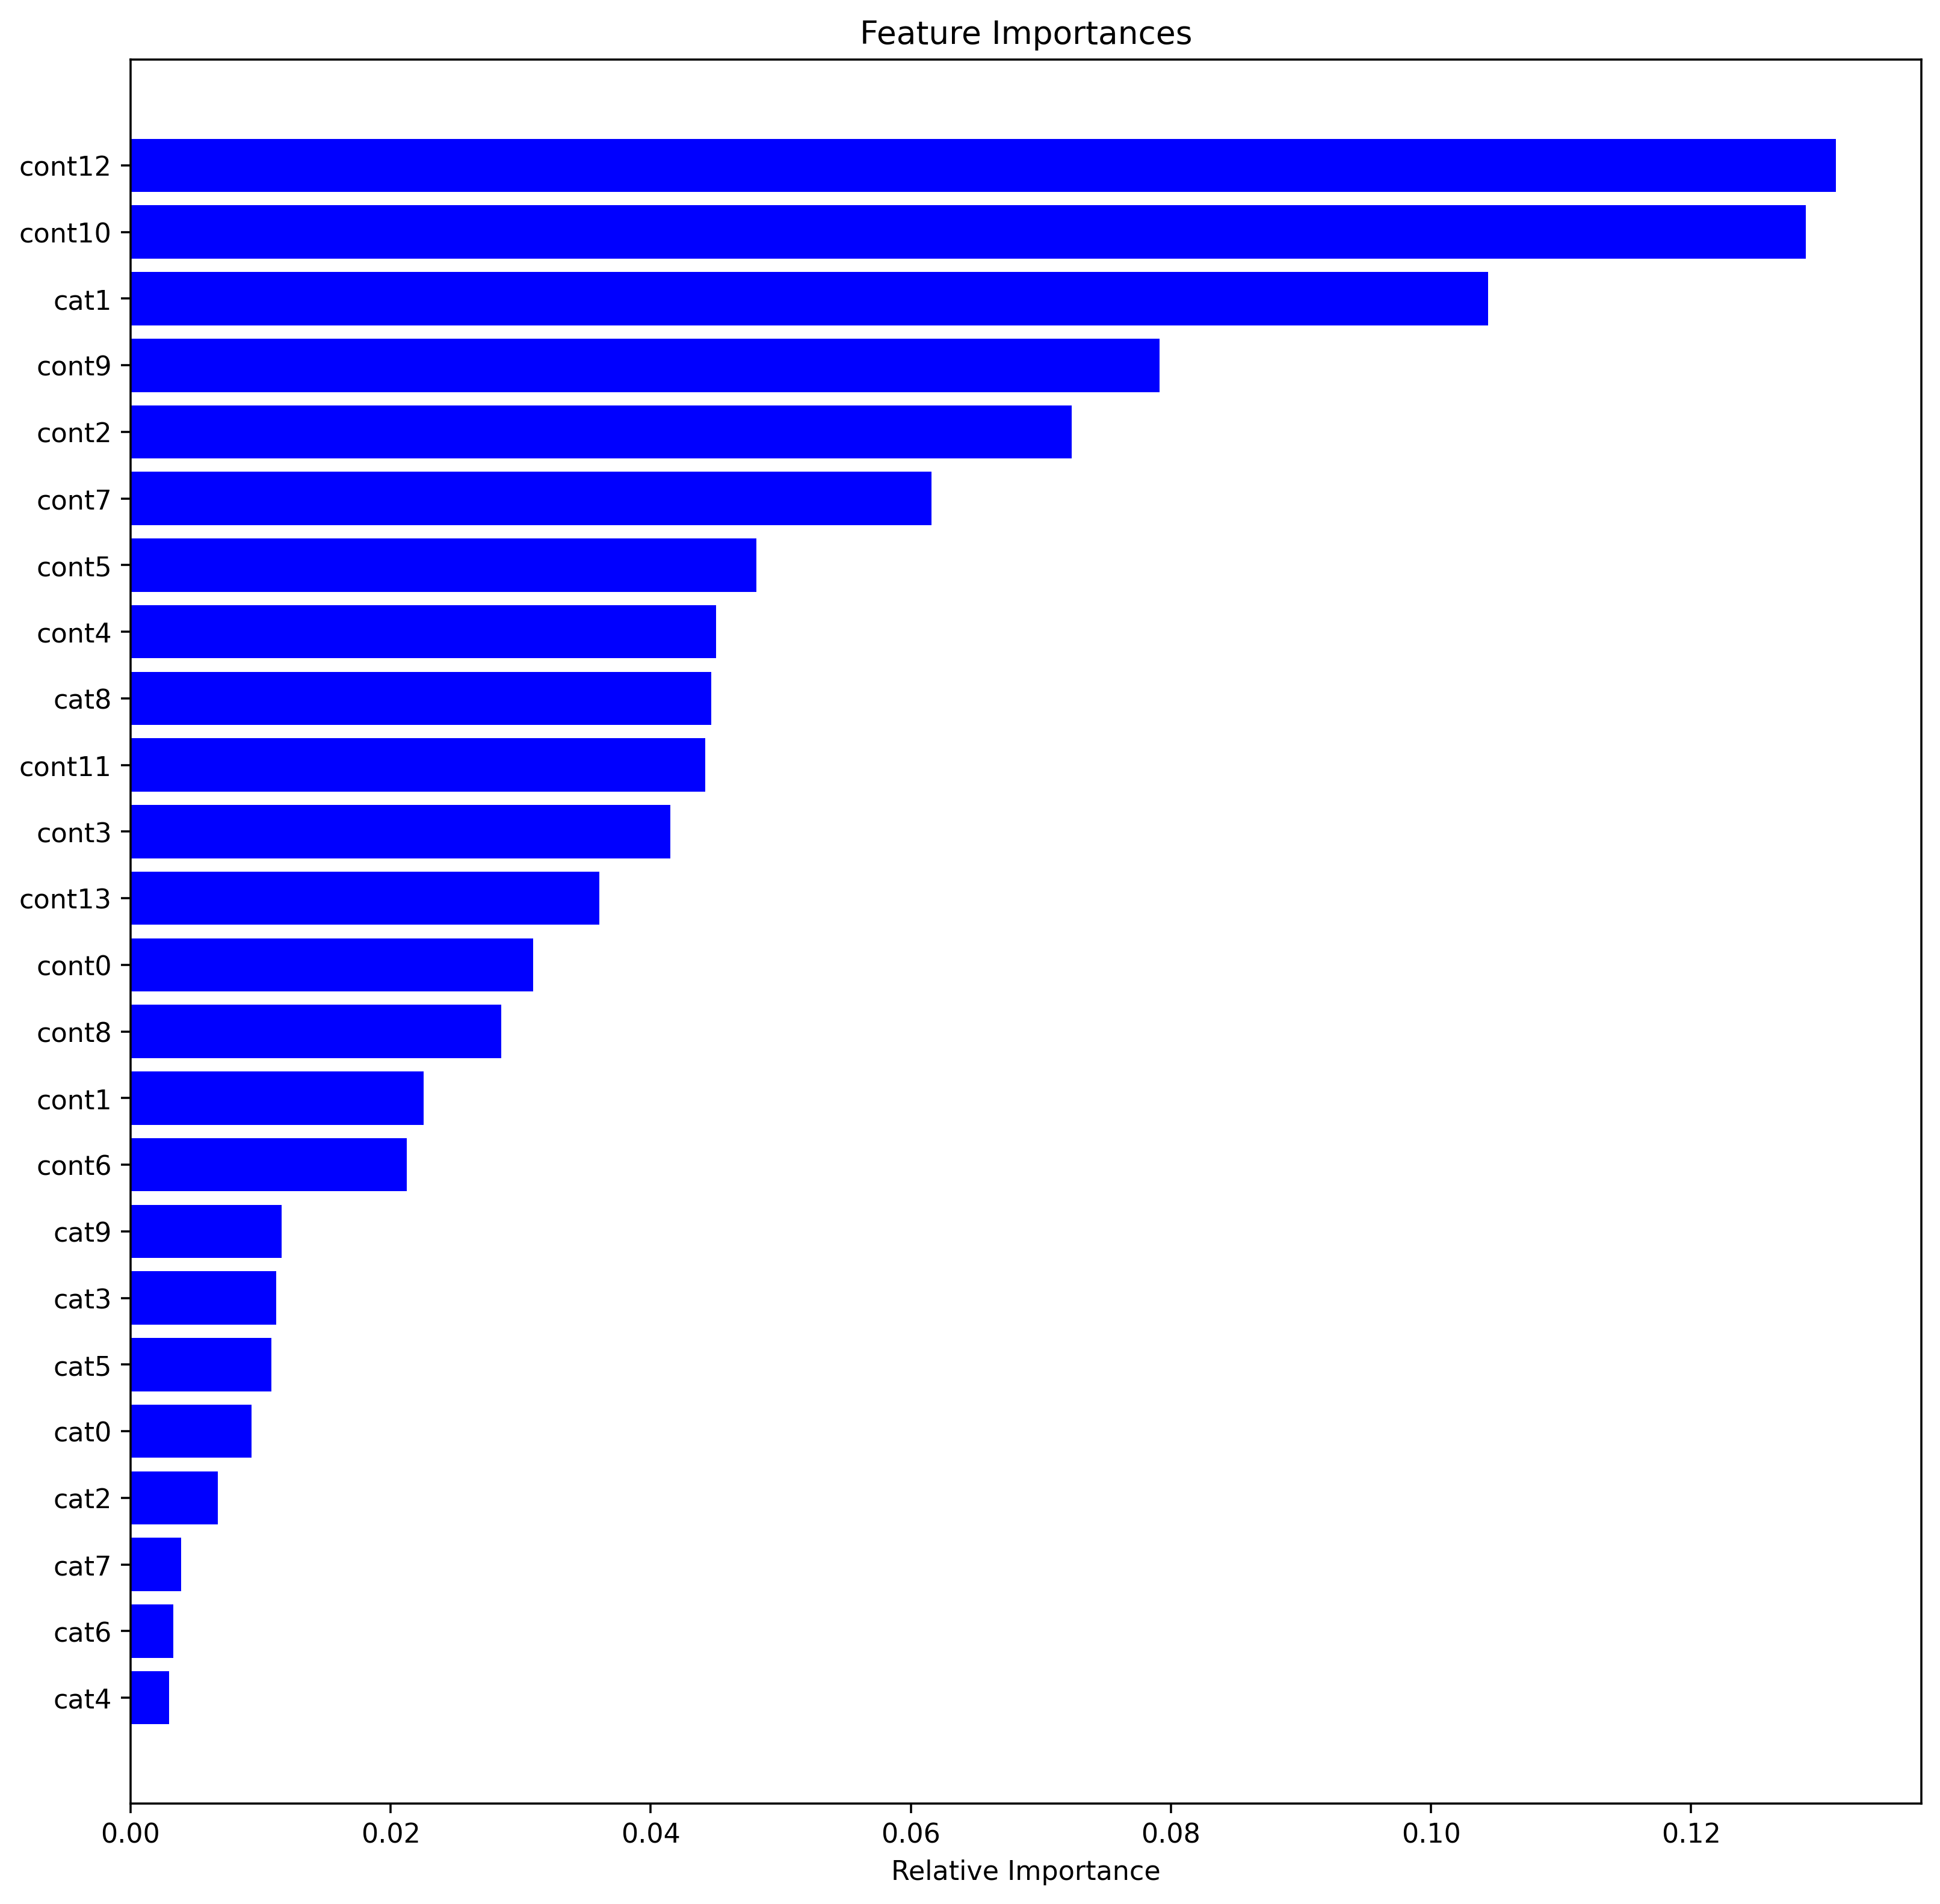

In [9]:
# to print feature importances bar chart
features=X.columns
importances = model_fi
indices = np.argsort(importances)
import matplotlib.pyplot as plt

plt.figure(1,figsize=(12,12), dpi=320)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)),features[indices])
plt.xlabel('Relative Importance')
plt.savefig('books_read.png')

In [10]:
output = pd.DataFrame({'id': X_test_full.index,
                       'target': preds})
output.to_csv('submission.csv', index=False)
